In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import time

import cell_type_constellations.serialization.ingestion as ingestion_utils
import cell_type_constellations.serialization.serialization as serialization_utils
import cell_type_constellations.geojson.geojson_api as geojson_api
import cell_type_constellations.geojson.geojson_plotting as geojson_plotting


In [2]:
scratch_dir = pathlib.Path('scratch')
assert scratch_dir.is_dir()

Point this to the directory where the CSVs defining the HMBA-BG taxonomy are

In [3]:
data_dir = pathlib.Path('../garage/BG_Aligned/data')
assert data_dir.is_dir()

The cell below can be replaced by the appropriate calls to `abc_atlas_access`

In [4]:
cell_to_cluster_path = data_dir /'cell_to_cluster_membership.csv'
assert cell_to_cluster_path.is_file()

cluster_membership_path = data_dir / 'cluster_to_cluster_annotation_membership.csv'
assert cluster_membership_path.is_file()

cluster_annotation_path = data_dir / 'cluster_annotation_term.csv'
assert cluster_annotation_path.is_file()

embedding_path = data_dir / 'cell_2d_embedding_coordinates.csv'
assert embedding_path.is_file()

hierarchy = ['Class', 'Subclass', 'Group', 'Cluster']

First, we need to generate the generalized constellation plot data and serialize it to an HDF5 file. This step will take ~ 15 minutes

In [5]:
h5_path = scratch_dir / 'bg_constellation.h5'

In [5]:
if not h5_path.exists():
    serialization_utils.serialize_from_csv(
            cell_to_cluster_path=cell_to_cluster_path,
            cluster_membership_path=cluster_membership_path,
            cluster_annotation_path=cluster_annotation_path,
            embedding_path=embedding_path,
            hierarchy=hierarchy,
            dst_path=h5_path,
            clobber=True,
            tmp_dir=scratch_dir,
            k_nn=15,
            n_processors=4
        )

=======finished one chunk of 100000 cells in 6.92e-02 minutes=======
=======finished one chunk of 100000 cells in 6.99e-02 minutes=======
=======finished one chunk of 100000 cells in 7.00e-02 minutes=======
=======finished one chunk of 100000 cells in 6.96e-02 minutes=======
=======finished one chunk of 100000 cells in 7.03e-02 minutes=======
=======finished one chunk of 100000 cells in 7.07e-02 minutes=======
=======finished one chunk of 100000 cells in 7.07e-02 minutes=======
=======finished one chunk of 100000 cells in 7.08e-02 minutes=======
=======finished one chunk of 100000 cells in 6.98e-02 minutes=======
=======finished one chunk of 100000 cells in 6.97e-02 minutes=======
=======finished one chunk of 100000 cells in 6.93e-02 minutes=======
=======finished one chunk of 100000 cells in 7.10e-02 minutes=======
=======finished one chunk of 100000 cells in 7.12e-02 minutes=======
=======finished one chunk of 100000 cells in 6.90e-02 minutes=======
=======finished one chunk of 10000

Next we will take the generalized constellation data and serialize one version of the constellation plot (at the "Group" level) in geojson format

In [6]:
geojson_path = scratch_dir / "group_constellation.geojson"

geojson_api.convert_constellation_to_geojson(
    src_hdf5_path=h5_path,
    dst_path=geojson_path,
    centroid_level='Group',
    hull_level='Group',
    connection_coords='embedding',
    clobber=True
)

Now let's do some plotting

In [7]:
level = 'Group'

# reuse some internal code to ingest the umap data
t0 = time.time()
ingested_data = ingestion_utils.from_csv(
    cell_to_cluster_path=cell_to_cluster_path,
    cluster_annotation_path=cluster_annotation_path,
    cluster_membership_path=cluster_membership_path,
    embedding_path=embedding_path,
    hierarchy=hierarchy
)
dur = (time.time()-t0)/60.0
print(f'ingesting data took {dur:.2e} minutes')



ingesting data took 5.15e-01 minutes


In [8]:
def get_umap_base_fig(
        color_map,
        cell_metadata,
        embedding_coords,
        color_by_level):
    """
    Create a figure and with the UMAP points plotted on it as a baseline
    for our visualization

    Parameters
    ----------
    color_map:
        dict mapping annotations to colors
        (as returned by ingestion_utils.from_csv)
    cell_metadata:
        dataframe of cell annotations
        (as returned by ingestion_utils.from_csv)
    embedding_coords:
        (n_cells, 2) ndarray of UMAP coords
        (same order as cells in cell_metadata)
    color_by_level:
        string indicating the level that we want to color by

    Return
    ------
    the matplotlib figure with the UMAP in it
    """
    t0 = time.time()

    rng = np.random.default_rng(2213111)

    fig = plt.figure(figsize=(10, 10))
    axis = fig.add_subplot(1,1,1)

    color_array = np.array([
        color_map[color_by_level][value]
        for value in cell_metadata[color_by_level].values
    ])

    idx = np.arange(len(color_array))
    rng.shuffle(idx)
    color_array = color_array[idx]
    x_arr = embedding_coords[idx, 0]
    y_arr = embedding_coords[idx, 1]

    axis.scatter(
        x_arr,
        y_arr,
        c=color_array,
        s=0.25,
        zorder=0
    )
    dur = time.time()-t0
    print(f'plotting the UMAP took {dur:.2e} seconds')
    return fig



plotting the UMAP took 1.36e+00 seconds
plotting constellation took 1.71e-01 seconds


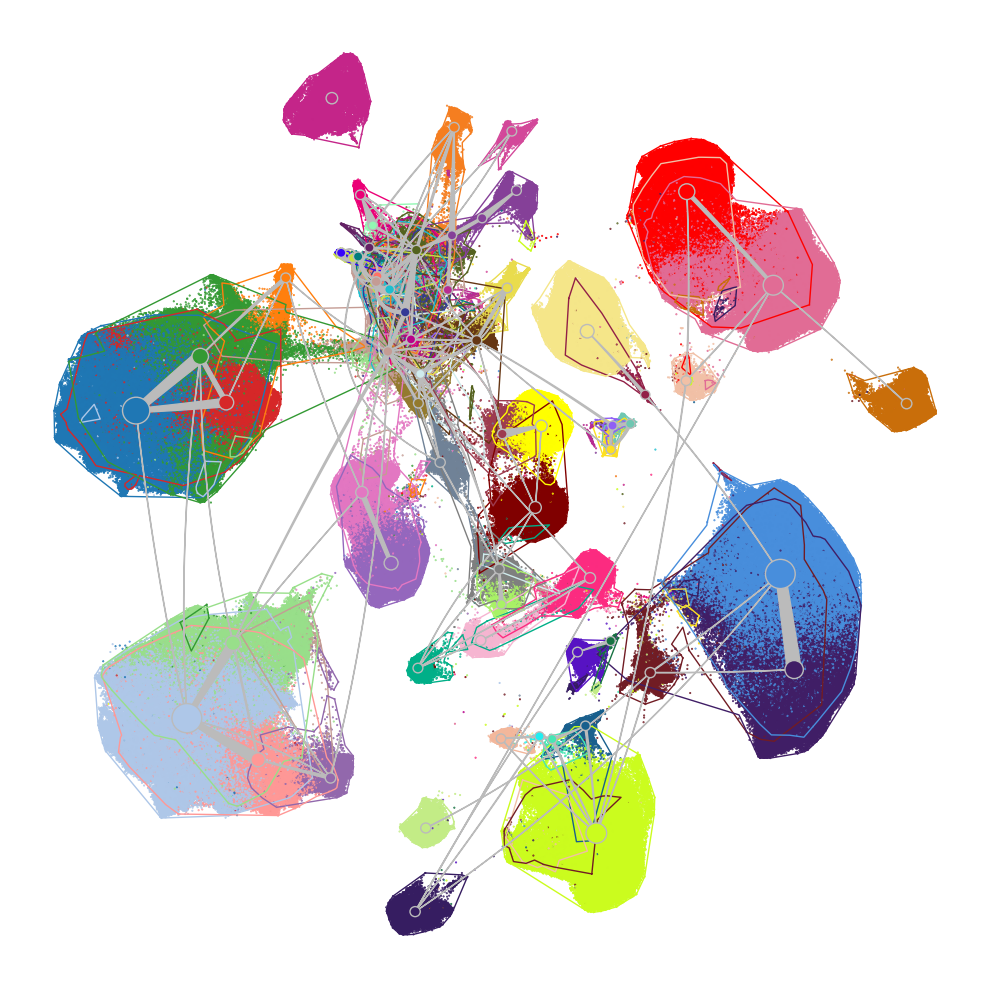

In [9]:
fig = get_umap_base_fig(
    color_map=ingested_data['discrete_color_map'],
    cell_metadata=ingested_data['cell_metadata'],
    embedding_coords=ingested_data['embedding_coords'],
    color_by_level=level
)

axis = fig.axes[0]

# actually plot the constellation plot from the geojson
t0 = time.time()
geojson_plotting.plot_geojson_constellation(
    geojson_path=geojson_path,
    axis=axis,
    zorder=1
)
dur = time.time()-t0
print(f'plotting constellation took {dur:.2e} seconds')

axis.set_axis_off()
fig.tight_layout()

Now without hulls

plotting the UMAP took 1.35e+00 seconds
plotting constellation took 1.41e-01 seconds


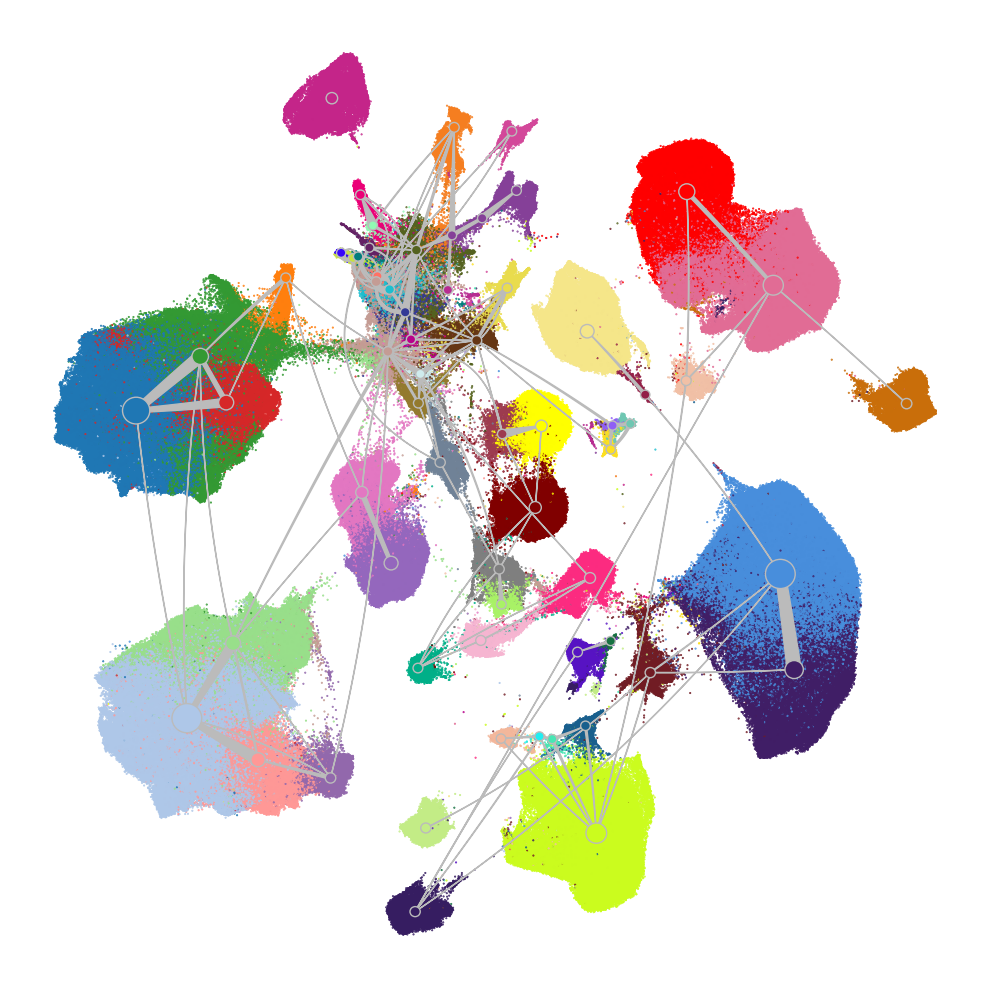

In [10]:
fig = get_umap_base_fig(
    color_map=ingested_data['discrete_color_map'],
    cell_metadata=ingested_data['cell_metadata'],
    embedding_coords=ingested_data['embedding_coords'],
    color_by_level=level
)

axis = fig.axes[0]

# actually plot the constellation plot from the geojson
t0 = time.time()
geojson_plotting.plot_geojson_constellation(
    geojson_path=geojson_path,
    axis=axis,
    zorder=1,
    plot_hulls=False
)
dur = time.time()-t0
print(f'plotting constellation took {dur:.2e} seconds')

axis.set_axis_off()
fig.tight_layout()